# Import library

In [1]:
import pandas as pd
from surprise import SVD ,NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


# Load Data

In [2]:
df = pd.read_csv('data/customer_data.csv',names = ['CustomerId','CustomerCode','CustomerName','AreaName','IndustryName','OrderNumber','OrderDate','ProductCode','ProductName','Length'],header=None)

In [3]:
df.head()

,CustomerId,CustomerCode,CustomerName,AreaName,IndustryName,OrderNumber,OrderDate,ProductCode,ProductName,Length
0,1662,GEORGR,GEORGE GRANT ENGINEERING LTD,AUCKLAND SOUTH,STEEL FABRICATORS,1086081,2013-12-16 15:48:39.167,PM010+24004500,PLATE MEDIUM TENSILE GR350,1.0
1,1662,GEORGR,GEORGE GRANT ENGINEERING LTD,AUCKLAND SOUTH,STEEL FABRICATORS,1093839,2014-01-29 14:09:07.887,PM010+24004500,PLATE MEDIUM TENSILE GR350,1.0
2,1662,GEORGR,GEORGE GRANT ENGINEERING LTD,AUCKLAND SOUTH,STEEL FABRICATORS,(NUMBER),2014-06-04 00:00:00.000,PM010+24004500,PLATE MEDIUM TENSILE GR350,1.0
3,1662,GEORGR,GEORGE GRANT ENGINEERING LTD,AUCKLAND SOUTH,STEEL FABRICATORS,1132027,2014-06-05 17:53:39.143,PM010+24004500,PLATE MEDIUM TENSILE GR350,1.0
4,1662,GEORGR,GEORGE GRANT ENGINEERING LTD,AUCKLAND SOUTH,STEEL FABRICATORS,1147064,2014-07-22 11:25:19.037,PM010+24004500,PLATE MEDIUM TENSILE GR350,1.0


# Pre-Process data

In [4]:
df.drop(['CustomerCode','CustomerName','OrderNumber','OrderDate','ProductCode','Length'],axis=1,inplace=True)

In [5]:
df

,CustomerId,AreaName,IndustryName,ProductName
0,1662,AUCKLAND SOUTH,STEEL FABRICATORS,PLATE MEDIUM TENSILE GR350
1,1662,AUCKLAND SOUTH,STEEL FABRICATORS,PLATE MEDIUM TENSILE GR350
2,1662,AUCKLAND SOUTH,STEEL FABRICATORS,PLATE MEDIUM TENSILE GR350
3,1662,AUCKLAND SOUTH,STEEL FABRICATORS,PLATE MEDIUM TENSILE GR350
4,1662,AUCKLAND SOUTH,STEEL FABRICATORS,PLATE MEDIUM TENSILE GR350
...,...,...,...,...
19995,595,AUCKLAND WEST,MANUFACTURERS,SHS NOP AS/NZS 1163 G450 LO
19996,479,AUCKLAND NORTH,STEEL FABRICATORS,SHS NOP AS/NZS 1163 G450 LO
19997,3121,AUCKLAND WEST,STRUCTURAL CONSTRUCTION,SHS NOP AS/NZS 1163 G450 LO
19998,3121,AUCKLAND WEST,STRUCTURAL CONSTRUCTION,SHS NOP AS/NZS 1163 G450 LO


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
# df['ProductCount'] = df.groupby(['CustomerId', 'ProductName'])['ProductName'].transform('count')
df['ProductCount'] = 1
pivoted_df = df.groupby(['CustomerId', 'ProductName']).sum().reset_index()


In [8]:
pivoted_df

,CustomerId,ProductName,AreaName,IndustryName,ProductCount
0,2,E.W.S.SQUARE TUBE,WAIRARAPA DISTRICT,MANUFACTURERS,1
1,2,PLATE MEDIUM TENSILE GR350,WAIRARAPA DISTRICT,MANUFACTURERS,1
2,2,RHS NOP AS 1163 C350 LO,WAIRARAPA DISTRICT,MANUFACTURERS,1
3,2,SHEET ELECTRO GALV,WAIRARAPA DISTRICT,MANUFACTURERS,1
4,3,SHEET ELECTRO GALV,AUCKLAND WEST,MANUFACTURERS,1
...,...,...,...,...,...
3835,12279,SHEET ELECTRO GALV,WELLINGTON,RESELLER/COMPETITOR,1
3836,12379,BLK PIPE LGT P/E(33.7OD) AS1074 C250,SOUTH CANTERBURY,GENERAL ENGINEERING,1
3837,12384,BLK PIPE LGT P/E(33.7OD) AS1074 C250,WELLINGTON,MANUFACTURERS,1
3838,13963,BLK PIPE LGT P/E(33.7OD) AS1074 C250,AUCKLAND EAST,UNDEFINED,1


In [9]:
reader = Reader()
data = Dataset.load_from_df(pivoted_df[['CustomerId', 'ProductName', 'ProductCount']], reader)

In [10]:
data

# Split data

In [161]:
trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()

In [162]:
def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

# SVD Model

In [163]:
rmse_svd = rmse_vs_factors(SVD,data)
rmse_svd

[0.002199108823799219,
 0.0025564357024146977,
 0.003417390209623671,
 0.004594304182936987,
 0.004501647721432407,
 0.004754759087334744,
 0.005978031299806894,
 0.005578512627619447,
 0.006302338586471415,
 0.007347409067751792,
 0.00754621349387298,
 0.00766848790334552,
 0.007708820140389071,
 0.0077870178869473535,
 0.008857465689235048,
 0.008285186153744718,
 0.008460306283713404,
 0.008972812143748449,
 0.009544609214398038,
 0.009698414142995677,
 0.009458617237444903,
 0.010165350468746491,
 0.010339635731529236,
 0.010031159207271004,
 0.010573389931832614,
 0.011405065299414882,
 0.010910354850004732,
 0.012208526265589709,
 0.011336761433718078,
 0.010796958089018852,
 0.011784003270486792,
 0.012772387692099249,
 0.012980647374554077,
 0.012437868485735606,
 0.012815641269991466,
 0.01246239297064465,
 0.012169831586777435,
 0.012976360384574323,
 0.013095680704290565,
 0.012636589791083752,
 0.013188001708422891,
 0.014937938154979472,
 0.013905917443710175,
 0.015223609

### Plot RMSV Vs Factor

In [164]:
def plot_rmse(rmse, algorithm):
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

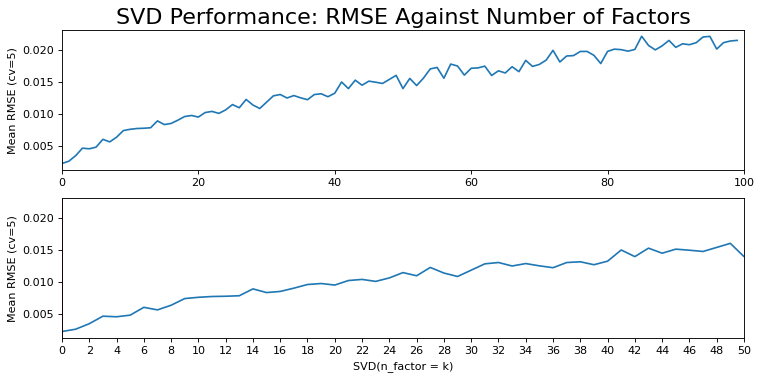

In [165]:
plot_rmse(rmse_svd,"SVD")

According to the figure, there is an increasing trend of worse performance with higher k. The lowest RMSE is achieved when 
k = 3


In [166]:
param_grid = {'n_factors': [3,4,6,9,11,14,18,29]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.0036832210327979236
{'n_factors': 3}


In [167]:
algo_SVD = SVD(n_factors = 3)
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
# testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

In [168]:
def get_top_n(predictions, customer_id, n=10): 
    # Create a defaultdict to store top N predictions for each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort the predictions for the given customer and retrieve the top N.
    top_n_cust = sorted(top_n[customer_id], key=lambda x: x[1], reverse=True)[:n]

    # Get the customer's historical interactions.
    hist_cust = pivoted_df[pivoted_df['CustomerId'] == customer_id].sort_values('ProductCount', ascending=False)
    
    # Create a DataFrame of recommended products.
    top_n_cust = pd.DataFrame(top_n_cust, columns=['ProductId', 'Estimated score'])
    
    top_n_cust = top_n_cust.sort_values('Estimated score', ascending=False)
    return hist_cust, top_n_cust


In [169]:
hist_data, pred_data = get_top_n(predictions, 1662)


In [170]:
pred_data

,ProductId,Estimated score
0,COLORSTEEL DESERT SAND ENDURA G300,1.034748
1,COLORSTEEL CLOUD ENDURA G300,1.030469
2,Plate Medium Tensile,1.016870
3,SHS C350 Painted,1.012967
4,RYDAL FLAT S1010,1.005763
5,PLATE AS 3678-450,1.004147
6,E.W.S.SQUARE TUBE,1.003921
7,UNEQUAL ANGLE AS/NZS 3679 GRADE 300,1.003355
8,RHS NOP AS 1163 C350 LO,1.000000
9,SHEET ELECTRO GALV,1.000000


In [171]:
df[df['ProductName'] == 'COLORSTEEL ENDURA CLOUD ENDURA G300']

,CustomerId,AreaName,IndustryName,ProductName,ProductCount
33,993,AUCKLAND WEST,UNDEFINED,COLORSTEEL ENDURA CLOUD ENDURA G300,1
43,1981,CHCH NORTH,GENERAL ENGINEERING,COLORSTEEL ENDURA CLOUD ENDURA G300,1
44,779,CH COIL PROCESSING,ROLLFORMERS,COLORSTEEL ENDURA CLOUD ENDURA G300,1
45,4096,CH COIL PROCESSING,MANUFACTURERS,COLORSTEEL ENDURA CLOUD ENDURA G300,1
102,1450,AUCKLAND SOUTH,MANUFACTURERS,COLORSTEEL ENDURA CLOUD ENDURA G300,1
104,2005,CHCH EAST,SHEETMETAL ENGINEERS,COLORSTEEL ENDURA CLOUD ENDURA G300,1
105,3877,CH COIL PROCESSING,UNDEFINED,COLORSTEEL ENDURA CLOUD ENDURA G300,1
255,4696,CH COIL PROCESSING,UNDEFINED,COLORSTEEL ENDURA CLOUD ENDURA G300,1
348,873,CH COIL PROCESSING,ROLLFORMERS,COLORSTEEL ENDURA CLOUD ENDURA G300,1
639,4783,WHAK-KAWER-OPOTIKI,GENERAL ENGINEERING,COLORSTEEL ENDURA CLOUD ENDURA G300,1


# NMF model

In [172]:
rmse_nmf = rmse_vs_factors(NMF, data)

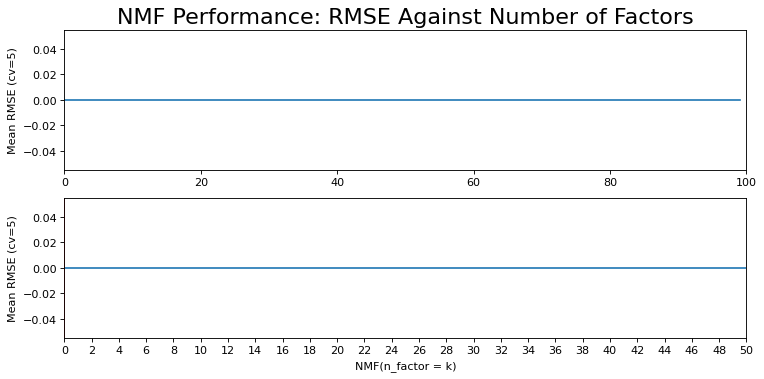

In [173]:
plot_rmse(rmse_nmf, "NMF")

above model not work in give data model is overfitting

In [174]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)


# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [175]:
hist_data, pred_data = get_top_n(predictions, customer_id = 1662)

In [176]:
pred_data

,ProductId,Estimated score
0,E.W.S.SQUARE TUBE,1
1,RHS NOP AS 1163 C350 LO,1
2,SHEET ELECTRO GALV,1
3,RYDAL FLAT S1010,1
4,BLK PIPE LGT P/E(33.7OD) AS1074 C250,1
5,UNEQUAL ANGLE AS/NZS 3679 GRADE 300,1
6,GALV PIPE MED S/S (114.1OD) AS1074 C250,1
7,SHS C350 Painted,1
8,COLORSTEEL DESERT SAND ENDURA G300,1
9,BRIGHT FREE CUTTING,1
